We will try:
- Naive Seasonal (7-day)
- Moving Average (7-day)
- Naive Seasonal (30-day)

*Update: Shifted to hourly*

Loading crime data...

Loaded 19,119 crime incidents

Date range: 2021-01-01 13:39:11 to 2024-12-31 19:45:00

Aggregating to hourly crime counts...

Total hours: 35047

Creating train/test split...

Train set: 26267 hours (2021-01-01 13:00:00 to 2023-12-31 23:00:00)

Test set: 8780 hours (2024-01-01 00:00:00 to 2024-12-31 19:00:00)

=== Building Baseline Models ===

1. Naive Seasonal (24-hour / Daily)

   Using values from 24 hours prior (daily pattern)

2. Naive Seasonal (168-hour / Weekly)

   Using values from 168 hours prior (weekly pattern)

3. Moving Average (24-hour)

   Using 24-hour rolling average

=== Baseline Model Results ===

        Baseline Model Performance (2024 Test Set)         
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━━━┓
┃ Rank ┃ Model                   ┃  MAE ┃ RMSE ┃ MAPE (%) ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━━━┩
│  #1  │ Moving Average (24-hr)  │ 0.68 │ 0.84 │   50.20% │
├──────┼─────────────────────────┼──────┼──────┼──────────┤
│  #2  │ Naive Seasonal (24-hr)  │ 0.72 │ 1.05 │   75.60% │
├──────┼─────────────────────────┼──────┼──────┼──────────┤
│  #3  │ Naive Seasonal (168-hr) │ 0.73 │ 1.10 │   74.06% │
└──────┴─────────────────────────┴──────┴──────┴──────────┘

Creating visualization...

Visualization complete!

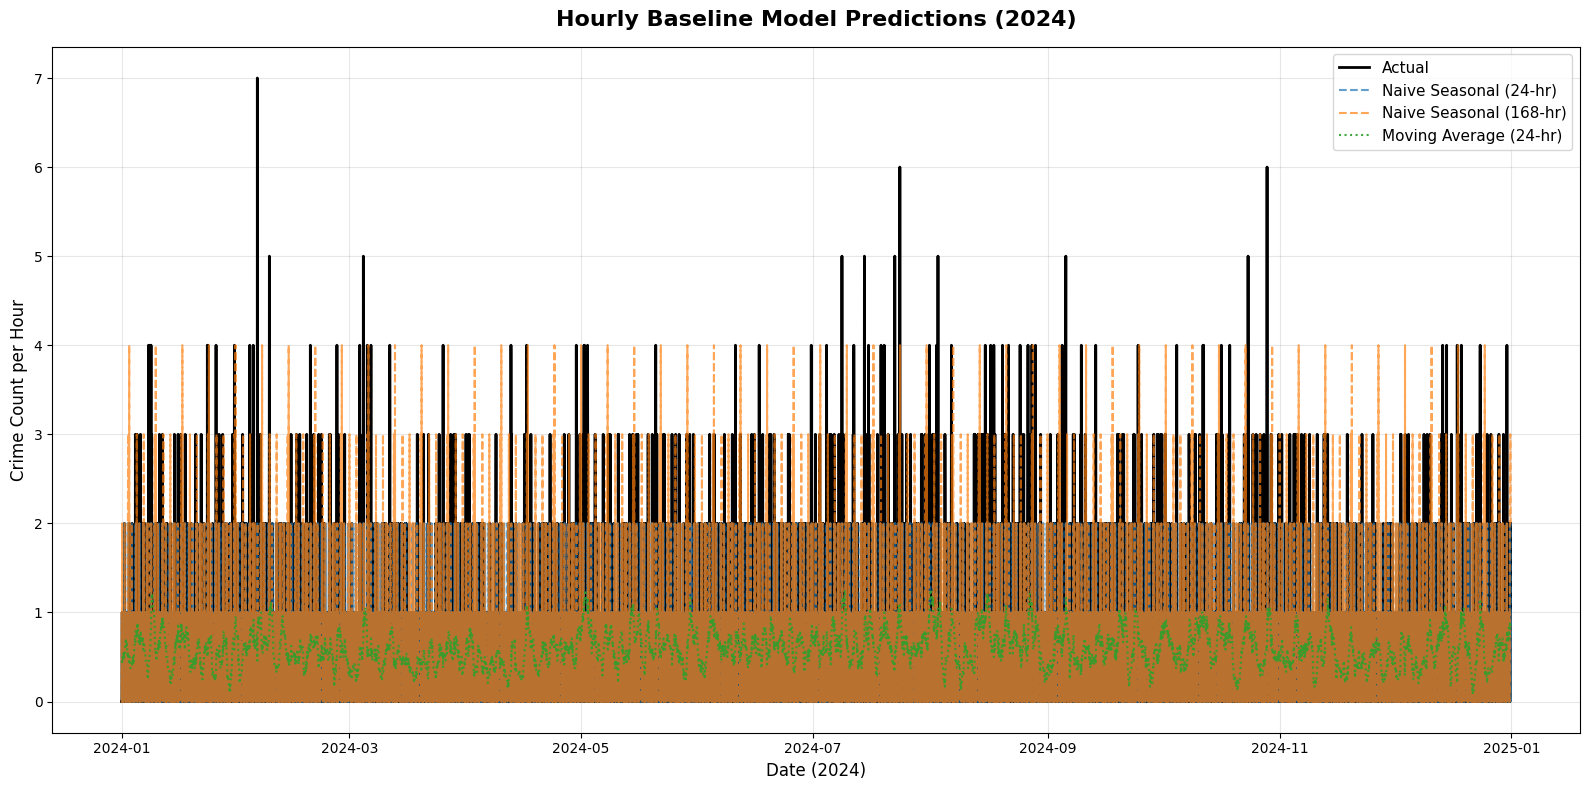

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from rich.console import Console
from rich.table import Table
import warnings
warnings.filterwarnings('ignore')

# --- 0. Setup ---
console = Console()

# --- 1. LOAD DATA ---
console.print("Loading crime data...", style="bold blue")
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v8.csv"
df = pd.read_csv(crime_csv_path)

df['ReportDate'] = pd.to_datetime(df['ReportDate'])
df = df.sort_values('ReportDate')

console.print(f"Loaded {len(df):,} crime incidents", style="green")
console.print(f"Date range: {df['ReportDate'].min()} to {df['ReportDate'].max()}", style="cyan")

# --- 2. AGGREGATE TO HOURLY COUNTS ---
console.print("\nAggregating to hourly crime counts...", style="bold blue")
hourly_counts = df.groupby(df['ReportDate'].dt.floor('H')).size().reset_index(name='crime_count')
hourly_counts = hourly_counts.rename(columns={'ReportDate': 'date'})
date_range = pd.date_range(start=hourly_counts['date'].min(), 
                           end=hourly_counts['date'].max(), 
                           freq='H')
hourly_counts = hourly_counts.set_index('date').reindex(date_range, fill_value=0)
hourly_counts = hourly_counts.reset_index().rename(columns={'index': 'date'})
console.print(f"Total hours: {len(hourly_counts)}", style="green")

# --- 3. TRAIN/TEST SPLIT ---
console.print("\nCreating train/test split...", style="bold blue")
train = hourly_counts[hourly_counts['date'] < '2024-01-01'].copy()
test = hourly_counts[hourly_counts['date'] >= '2024-01-01'].copy()

if train.empty or test.empty:
    console.print("Error: Train or test set is empty. Check your date range.", style="bold red")
else:
    console.print(f"Train set: {len(train)} hours ({train['date'].min()} to {train['date'].max()})", style="cyan")
    console.print(f"Test set: {len(test)} hours ({test['date'].min()} to {test['date'].max()})", style="cyan")

# --- 4. BASELINE MODELS ---
console.print("\n=== Building Baseline Models ===", style="bold yellow")

# --- NEW/FIXED: calculate_metrics function ---
def calculate_metrics(actual, predicted, model_name):
    """Calculate regression metrics with a 'safe' MAPE"""
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # --- Safe MAPE Calculation ---
    # Find all hours where the 'actual' count was NOT zero
    non_zero_mask = actual != 0
    
    # If all actuals are zero, MAPE is undefined (NaN)
    if not np.any(non_zero_mask):
        mape = np.nan
    else:
        # Calculate MAPE *only* for the non-zero hours
        mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
    # --- End Safe MAPE ---
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }
# --- END FIX ---

results = []
mean_value = train['crime_count'].mean()

# --- MODEL 1: NAIVE SEASONAL (24-hour / Daily) ---
console.print("\n1. Naive Seasonal (24-hour / Daily)", style="bold")
seasonal_24_pred = []
for i in range(len(test)):
    lookback_idx = len(train) - 24 + (i % 24) 
    if lookback_idx >= 0:
        seasonal_24_pred.append(train['crime_count'].iloc[lookback_idx])
    else:
        seasonal_24_pred.append(mean_value)
results.append(calculate_metrics(test['crime_count'], seasonal_24_pred, 'Naive Seasonal (24-hr)'))
console.print(f"   Using values from 24 hours prior (daily pattern)", style="dim")

# --- MODEL 2: NAIVE SEASONAL (168-hour / Weekly) ---
console.print("\n2. Naive Seasonal (168-hour / Weekly)", style="bold")
seasonal_168_pred = []
for i in range(len(test)):
    lookback_idx = len(train) - 168 + (i % 168) 
    if lookback_idx >= 0:
        seasonal_168_pred.append(train['crime_count'].iloc[lookback_idx])
    else:
        seasonal_168_pred.append(mean_value)
results.append(calculate_metrics(test['crime_count'], seasonal_168_pred, 'Naive Seasonal (168-hr)'))
console.print(f"   Using values from 168 hours prior (weekly pattern)", style="dim")
    
# --- MODEL 3: MOVING AVERAGE (24-hour) ---
console.print("\n3. Moving Average (24-hour)", style="bold")
ma_24_pred = []
window_size = 24
for i in range(len(test)):
    if i == 0:
        ma_value = train['crime_count'].iloc[-window_size:].mean()
    else:
        recent_values = list(train['crime_count'].iloc[-(window_size-i):]) + list(test['crime_count'].iloc[:i])
        ma_value = np.mean(recent_values[-window_size:])
    ma_24_pred.append(ma_value)
results.append(calculate_metrics(test['crime_count'], ma_24_pred, 'Moving Average (24-hr)'))
console.print(f"   Using 24-hour rolling average", style="dim")

# --- 5. DISPLAY RESULTS ---
console.print("\n=== Baseline Model Results ===", style="bold green")
results_df = pd.DataFrame(results).sort_values('MAE')

table = Table(title="Baseline Model Performance (2024 Test Set)", show_lines=True)
table.add_column("Rank", style="dim", justify="center")
table.add_column("Model", style="cyan", no_wrap=True)
table.add_column("MAE", justify="right", style="magenta")
table.add_column("RMSE", justify="right", style="yellow")
table.add_column("MAPE (%)", justify="right", style="green")

for rank, (_, row) in enumerate(results_df.iterrows(), 1):
    table.add_row(
        f"#{rank}",
        row['Model'],
        f"{row['MAE']:.2f}",
        f"{row['RMSE']:.2f}",
        f"{row['MAPE']:.2f}%"
    )
console.print(table)

# --- 6. VISUALIZE PREDICTIONS ---
console.print("\nCreating visualization...", style="bold blue")
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(test['date'], test['crime_count'], label='Actual', color='black', linewidth=2.0)
ax.plot(test['date'], seasonal_24_pred, label='Naive Seasonal (24-hr)', linestyle='--', alpha=0.7)
ax.plot(test['date'], seasonal_168_pred, label='Naive Seasonal (168-hr)', linestyle='--', alpha=0.7)
ax.plot(test['date'], ma_24_pred, label='Moving Average (24-hr)', linestyle=':', alpha=0.9)
ax.set_title('Hourly Baseline Model Predictions (2024)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Date (2024)', fontsize=12)
ax.set_ylabel('Crime Count per Hour', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
console.print("Visualization complete!", style="bold green")
plt.show()